In [ ]:
%tensorflow_version 2.1

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import io
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [23]:
# Print versions
!python --versions
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

unknown option --versions
usage: python3 [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.
Numpy 1.26.4
TensorFlow 2.18.0
Keras 3.8.0


In [40]:
# Import Data
print("\n---- Dataset Info ----")
gesture_data = pd.read_csv('https://raw.githubusercontent.com/yavrohatgi/SignSpeak/refs/heads/main/ML/final/v1/gesture_data_augmented.csv?token=GHSAT0AAAAAAC63N3IGBBNGZFLB2C3G4V5WZ5WJBTQ')


# Separate features (first 28 columns) and labels (last column)
x = gesture_data.iloc[:, :-1].values  # Features (28 columns)
y = gesture_data.iloc[:, -1].values   # Labels (gesture class, column 29)

# Convert string labels to numeric (0-3)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Save the encoder for future use (important for inference)
joblib.dump(label_encoder, "label_encoder.pkl")

# Print dataset info
print(f"gesture_data.shape = {gesture_data.shape}")
print(f"features.shape = {x.shape}")
print(f"labels.shape = {y.shape}")
print("Label Mapping:", label_mapping)
print("\n")


---- Dataset Info ----
gesture_data.shape = (1700, 29)
features.shape = (1700, 28)
labels.shape = (1700,)
Label Mapping: {'down': 0, 'left': 1, 'right': 2, 'up': 3}




In [41]:
# Settings
inputShape = (28,)
nsamples = 1700     # Number of samples to use as a dataset
val_ratio = 0.1     # % of samples that should be held for validation set
test_ratio = 0.1    # % of samples that should be held for test set
tflite_model_name = 'SIGNSPEAK_MLP_1finger_model'    # Will be given .tflite suffix
c_model_name = 'SIGNSPEAK_MLP_1finger_model'         # Will be given .h suffix

Training: (1360, 28), Validation: (170, 28), Testing: (170, 28)


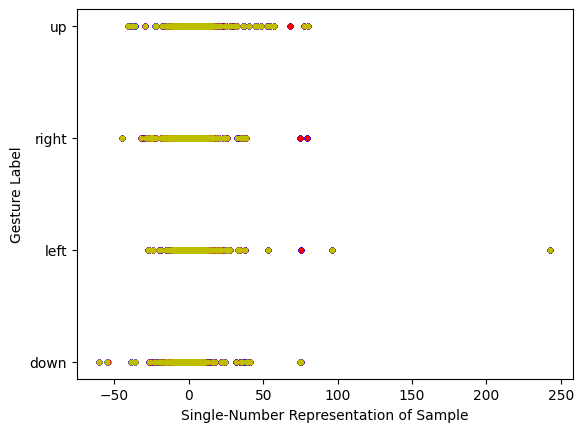

In [56]:
# Split the dataset into training, validation, and test sets (80% train, 10% validation, 10% test)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training: {x_train.shape}, Validation: {x_val.shape}, Testing: {x_test.shape}")

# Check that our splits add up to nsamples
assert(x_train.shape[0] + x_val.shape[0] + x_test.shape[0]) == nsamples

# Get unique numerical labels and corresponding string labels
unique_labels = np.unique(y)
string_labels = label_encoder.inverse_transform(unique_labels)

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")


plt.yticks(unique_labels, string_labels) # Set y-axis ticks and labels

plt.xlabel("Single-Number Representation of Sample") #
plt.ylabel("Gesture Label")
plt.show()

In [ ]:
# Normalize features (assuming X contains raw sensor data)
'''
scaler = MinMaxScaler(feature_range=(-1,1))  # Normalize between -1 and 1
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to NumPy arrays (if not already)
import numpy as np
X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)
'''

In [57]:
# Create a model
model = tf.keras.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=inputShape))
#model.add(layers.Dropout(0.2)) # Prevent Overfitting
model.add(layers.Dense(32, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='softmax')) # 4 gesture classes

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
# View model
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 64)                  │           1,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,068 (15.89 KB)

 Trainable params: 4,068 (15.89 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

In [60]:
# Train model
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=16,  # Small batch size for generalization
                    validation_data=(x_val, y_val))


Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4405 - loss: 2.4575 - val_accuracy: 0.9412 - val_loss: 0.3011
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9386 - loss: 0.2282 - val_accuracy: 0.9588 - val_loss: 0.1561
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9694 - loss: 0.1200 - val_accuracy: 0.9706 - val_loss: 0.0985
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9941 - loss: 0.0838 - val_accuracy: 1.0000 - val_loss: 0.0627
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.0581 - val_accuracy: 1.0000 - val_loss: 0.0429
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0329 - val_accuracy: 1.0000 - val_loss: 0.0295
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0284 - val_accuracy: 1.0000 - val_loss: 0.0215
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0164 - val_accuracy: 1.0000 - val_loss:

'\nhistory = model.fit(x_train,\n                    y_train,\n                    epochs=500,\n                    batch_size=100,\n                    validation_data=(x_val, y_val))\n'

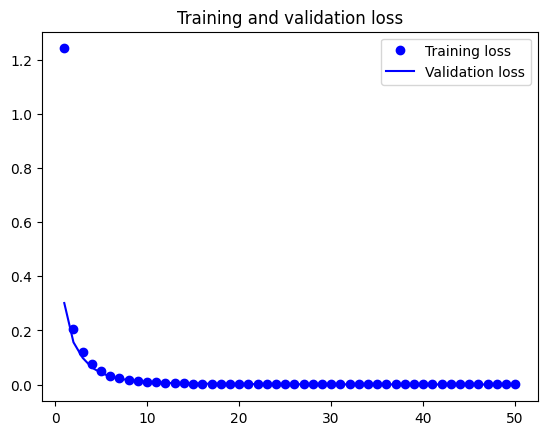

In [61]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


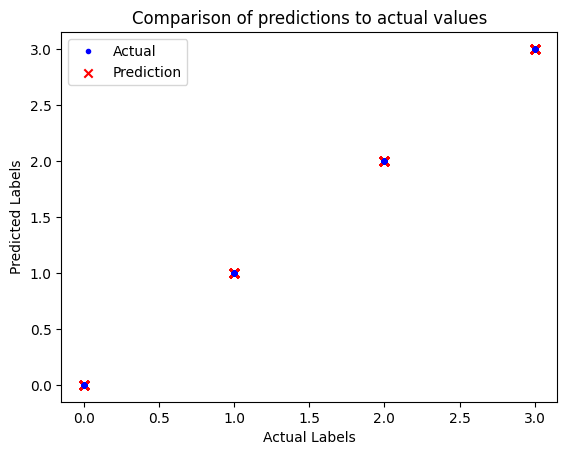

In [62]:
# Plot predictions against actual values
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)  # Get predicted class labels

plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(y_test, y_test, 'b.', label='Actual') # Plot actual vs actual for diagonal line
plt.scatter(y_test, predicted_labels, c='r', marker='x', label='Prediction') # Scatter predicted vs actual
plt.xlabel("Actual Labels")
plt.ylabel("Predicted Labels")
plt.legend()
plt.show()



In [63]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8296e-04 
Test Accuracy: 1.0000


In [64]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

Saved artifact at '/tmp/tmp6s4j1e3k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28), dtype=tf.float32, name='keras_tensor_30')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139947562358096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139947562358672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139947562358288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139947562359824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139947562359440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139947562360592: TensorSpec(shape=(), dtype=tf.resource, name=None)


8088

In [ ]:
# ***** --- Continue from 8:00 in tutorial --- *****